In [21]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from datetime import timezone, datetime
import seaborn as sns
from matplotlib import pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [22]:
imputedMeasurementsDf = pd.read_csv('../../../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')
measurementsDf = pd.read_csv('../../../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [23]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [24]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [25]:
%%time

iso8601ToDatetime()

CPU times: total: 12.3 s
Wall time: 12.7 s


In [26]:
measurementsDf = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))

In [27]:
measurementsDf.head(20)

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
5,2020-07-14 19:00:00,30.647222,1585.713833,29.133333,101.567130,400.000000,D0001
6,2020-07-14 20:00:00,29.891429,1585.713833,28.597143,101.567130,400.000000,D0001
7,2020-07-14 21:00:00,29.118919,1585.713833,29.162162,101.567130,400.000000,D0001
8,2020-07-14 22:00:00,28.200000,1585.713833,31.611111,101.567130,400.000000,D0001
9,2020-07-14 23:00:00,28.280556,1389.856833,32.111111,101.296439,441.916667,D0001


In [28]:
measurementsDf.index =measurementsDf['time']

<AxesSubplot:xlabel='time'>

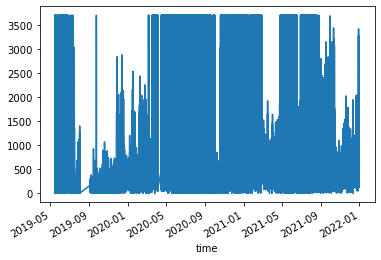

In [29]:
measurementsDf['Rn'].plot()

In [30]:
RadonDf =pd.DataFrame( measurementsDf['Rn'])
RadonDf 

,Rn
time,
2020-07-14 14:00:00,1001.448424
2020-07-14 15:00:00,588.154974
2020-07-14 16:00:00,0.100000
2020-07-14 17:00:00,1042.843803
2020-07-14 18:00:00,1585.713833
...,...
2021-12-31 19:00:00,616.640000
2021-12-31 20:00:00,541.380000
2021-12-31 21:00:00,544.167273


In [31]:
RadonDf['H'] = measurementsDf['H']
RadonDf['CO2'] = measurementsDf['CO2']
RadonDf['P'] = measurementsDf['P']
RadonDf['T'] = measurementsDf['T']
RadonDf

,Rn,H,CO2,P,T
time,,,,,
2020-07-14 14:00:00,1001.448424,44.475000,567.750000,101.565847,31.300000
2020-07-14 15:00:00,588.154974,45.505556,636.361111,101.632854,31.333333
2020-07-14 16:00:00,0.100000,47.145714,734.000000,101.539128,31.451429
2020-07-14 17:00:00,1042.843803,36.000000,461.529412,101.501998,31.161765
2020-07-14 18:00:00,1585.713833,28.436111,400.000000,101.567130,31.008333
...,...,...,...,...,...
2021-12-31 19:00:00,616.640000,50.156364,97.200000,102.653100,29.792673
2021-12-31 20:00:00,541.380000,48.047273,97.800000,102.273400,29.951673
2021-12-31 21:00:00,544.167273,53.847273,97.181818,102.199727,30.329218


In [32]:
from sklearn.metrics import mean_squared_error as mse

def predictions_plotter(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [33]:
#Converts the Df to a numpy array and then extracts the X and y value
#on the required format to train the model
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy() # converts the dataframe to a numpy array
    #Initialized  arrays to append X and Y values 
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        #Takes values from i to i + win size
        row =  [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        #The final output
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [34]:
X1, y1 = df_to_X_y(RadonDf)
X1.shape, y1.shape

((115628, 6, 5), (115628,))

In [35]:
X_train, y_train = X1[:92508], y1[:92508] # training data
X_val, y_val = X1[92508:95508], y1[92508:95508] #validation
X_test, y_test = X1[95508:], y1[95508:] #test
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((92508, 6, 5), (92508,), (3000, 6, 5), (3000,), (20120, 6, 5), (20120,))

 <h2> <font color='red'> LSTM implementation </font> <h2/> 

In [57]:
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((6, 5)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [64]:
cp = ModelCheckpoint('LSTM_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), 
               optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

In [65]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
2891/2891 [==============================] - 26s 8ms/step - loss: 481741.9062 - root_mean_squared_error: 694.0763 - val_loss: 9673.5996 - val_root_mean_squared_error: 98.3545


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 2/10
2891/2891 [==============================] - 20s 7ms/step - loss: 374369.0000 - root_mean_squared_error: 611.8570 - val_loss: 9697.9473 - val_root_mean_squared_error: 98.4782
Epoch 3/10
2891/2891 [==============================] - 22s 8ms/step - loss: 277016.4375 - root_mean_squared_error: 526.3235 - val_loss: 9382.4707 - val_root_mean_squared_error: 96.8632


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 4/10
2891/2891 [==============================] - 21s 7ms/step - loss: 192945.1406 - root_mean_squared_error: 439.2552 - val_loss: 9443.0146 - val_root_mean_squared_error: 97.1752
Epoch 5/10
2891/2891 [==============================] - 22s 7ms/step - loss: 125884.6172 - root_mean_squared_error: 354.8022 - val_loss: 9516.5664 - val_root_mean_squared_error: 97.5529
Epoch 6/10
2891/2891 [==============================] - 21s 7ms/step - loss: 77005.8594 - root_mean_squared_error: 277.4993 - val_loss: 9763.1855 - val_root_mean_squared_error: 98.8088
Epoch 7/10
2891/2891 [==============================] - 23s 8ms/step - loss: 48365.4141 - root_mean_squared_error: 219.9214 - val_loss: 10384.3555 - val_root_mean_squared_error: 101.9037: 1s - loss: 49103
Epoch 8/10
2891/2891 [==============================] - 23s 8ms/step - loss: 37238.7227 - root_mean_squared_error: 192.9734 - val_loss: 10218.1729 - val_root_mean_squared_error: 101.085038882.6992 - root_mean_squared_error: 1 - ETA: 4s - 

In [66]:
model = load_model('LSTM_model/')

In [69]:
model.evaluate(X_test,y_test)


629/629 [==============================] - 2s 3ms/step - loss: 76104.1562 - root_mean_squared_error: 275.8698A: 1s - loss: 36137.6328 - root_ - ETA: 0s - loss: 86258.9141 - root_mean_squared_error: 293.


[76104.15625, 275.86981201171875]

In [72]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

In [73]:
train_results.head(30)

,Train Predictions,Actuals
0,1277.303101,1585.713833
1,1310.154785,1585.713833
2,1301.393677,1585.713833
3,1300.835815,1389.856833
4,1134.084839,1037.712333
5,984.282349,423.906944
6,575.745911,578.023500
7,697.004761,706.933161
8,812.207642,706.933161
9,754.300537,423.906944


In [38]:
plt.style.use('seaborn')

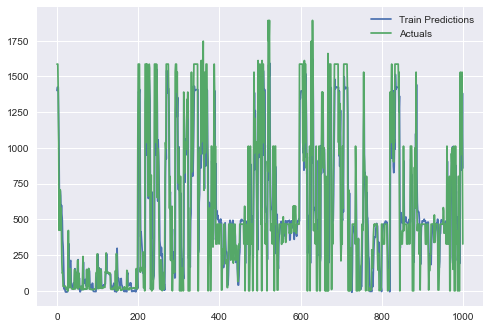

In [46]:
plt.plot(train_results['Train Predictions'][:1000],)
plt.plot(train_results['Actuals'][:1000])
plt.legend(['Train Predictions','Actuals'])


In [125]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})

In [126]:
print(len(val_predictions))
results=[]
for i in range(len(y_val)):
    diff = val_predictions[i] - y_val[i]  
    if(diff>100):
        print(diff)
    else:
        results.append(( abs(diff) /  y_val[i]) * 100)

3000
430.56859375
109.92488118489598
176.82645751953123
227.17731363932296
291.4466472833807
185.10336925159802
151.42937782981178
259.6799479166667
301.0960725911458
155.03457112630213
133.66895955403643
441.26572102864543
240.43847753906266
256.5992431640624
124.37410400390627
330.4371622721354
322.1296598307292
354.0533675130207
198.14175115411933
180.3660990767046
485.69257324218756
572.0177132161459
261.3568234592014
257.90486531575516
186.45667643229172
206.27439778645834
182.3193949381511
101.54023925781246
133.7703401692711
223.81367513020825
353.6064595170454
112.28664672851568
112.56515909830733
136.24079678622172
593.5237788529831
216.17622395833325
410.67143147786464
798.7705761718751
211.9690608723958
117.04436057350864
192.31154947916662
175.10804158528651
159.91456583658862
110.40643334960947
162.62016224254265
102.19812999378547
161.19962597656252
331.9748860677083
389.2569775390625
223.07407470703123
149.15113103693187
105.18492106119794
144.21469563802083
174.99933837

In [127]:
len(results)

2863

In [128]:
resultSum = sum(results)

In [124]:
resultSum/(len(results))

11.832238775560619

In [118]:
val_results.head(30)

,Val Predictions,Actuals
0,428.612152,469.725455
1,456.805786,438.566667
2,413.004059,419.945000
3,401.593903,434.873333
4,423.776276,421.390909
5,402.223114,441.125000
6,430.808594,0.240000
7,57.091682,355.225000
8,484.014252,475.210000
9,503.317047,616.751667


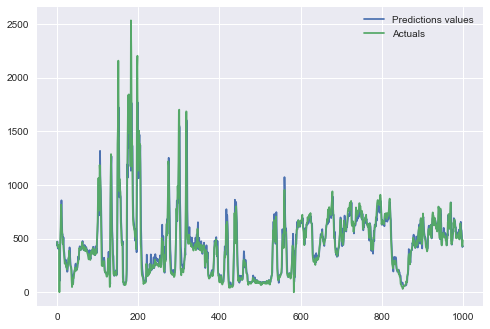

In [55]:
plt.plot(val_results['Val Predictions'][:1000])
plt.plot(val_results['Actuals'][:1000])
plt.legend(['Predictions values','Actuals'])

In [76]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

In [77]:
test_results.head(30)

,Test Predictions,Actuals
0,895.071960,862.405000
1,784.350952,841.680000
2,799.404175,854.633333
3,809.385986,853.469000
4,811.472961,890.230000
5,885.452271,815.413333
6,768.236938,811.605455
7,791.101135,804.932500
8,770.880737,808.569167
9,781.427917,822.270909


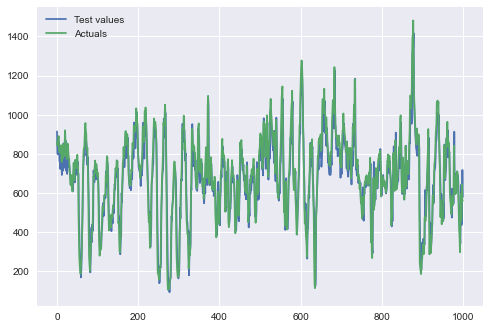

In [54]:
plt.plot(test_results['Test Predictions'][:1000])
plt.plot(test_results['Actuals'][:1000])
plt.legend(['Test values','Actuals'])